# Ginkgo Comparisons

## Preliminaries

In [24]:

import pyprob
import numpy as np
import ot
import torch
import cProfile
import pickle

from pyprob.dis import ModelDIS
from showerSim import invMass_ginkgo
from torch.utils.data import DataLoader
from pyprob.nn.dataset import OnlineDataset
from pyprob.util import InferenceEngine
from pyprob.util import to_tensor
from pyprob import Model
import math
from pyprob.distributions import Normal
from pyprob.distributions.delta import Delta


import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as mpl_cm
plt.ion()

from sbi import utils
from sbi import analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn


import sklearn as skl
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from joblib import Parallel, delayed

from geomloss import SamplesLoss
sinkhorn = SamplesLoss(loss="sinkhorn", p=1, blur=.05)
def sinkhorn_t(x,y):
    x = torch.as_tensor(x)
    y = torch.as_tensor(y)
    return sinkhorn(x,y)

def euclidean_major(x,y):
    x = torch.as_tensor(x, dtype=torch.float32).sort()[0]
    y = torch.as_tensor(y, dtype=torch.float32).sort()[0]
    return torch.linalg.norm(x-y)

def ot_dist(x,y):
    x = x.detach().numpy()
    y = y.detach().numpy()
    a = ot.unif(len(x))
    b = ot.unif(len(y))
    Mat = ot.dist(x, y, metric='euclidean')
    distance = torch.tensor(ot.emd2(a,b,Mat))
    return distance



## Prepare Simulator

In [25]:
QCD_mass = to_tensor(30.)
#rate=to_tensor([QCD_rate,QCD_rate]) #Entries: [root node, every other node] decaying rates. Choose same values for a QCD jet
jetdir = to_tensor([1.,1.,1.])
jetP = to_tensor(400.)
jetvec = jetP * jetdir / torch.linalg.norm(jetdir) ## Jetvec is 3-momentum. JetP is relativistic p.


# Actual parameters
pt_min = to_tensor(0.3**2)
M2start = to_tensor(QCD_mass**2)
jetM = torch.sqrt(M2start) ## Mass of initial jet
jet4vec = torch.cat((torch.sqrt(jetP**2 + jetM**2).reshape(-1), jetvec))
minLeaves = 1
maxLeaves = 10000 # unachievable, to prevent rejections
maxNTry = 100


simulator = invMass_ginkgo.SimulatorModel(jet_p=jet4vec,  # parent particle 4-vector
                                    pt_cut=float(pt_min),  # minimum pT for resulting jet
                                    Delta_0= M2start,  # parent particle mass squared -> needs tensor
                                    M_hard=jetM,  # parent particle mass
                                    minLeaves=1,  # minimum number of jet constituents
                                    maxLeaves=10000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                                    suppress_output=True)



In [26]:
true_params = torch.tensor([3,3])
synthetic_data = simulator(torch.tensor([3,3]))
synthetic_obs = synthetic_data['leaves']

true_params_2 = torch.tensor([5,9.5])
synthetic_data_2 = simulator(torch.tensor([5,9.5]))
synthetic_obs_2 = synthetic_data_2['leaves']

In [27]:
def simulation_wrapper_sinkhorn(data):
    """
    Uses euclidean distances from a given observation as summary
    """
    def parameter_wrapper(params):
        current_obs = simulator(params)['leaves']
        if current_obs.isnan().any():
            distance = np.inf
        else:
            distance = sinkhorn_t(data, current_obs)
        return torch.as_tensor([distance])
    
    return parameter_wrapper

In [28]:
def simulation_wrapper_ot(data):
    """
    Uses euclidean distances from a given observation as summary
    """
    def parameter_wrapper(params):
        current_obs = simulator(params)['leaves']
        if current_obs.isnan().any():
            distance = np.inf
        else:
            distance = ot_dist(data, current_obs)
        return torch.as_tensor([distance])
    
    return parameter_wrapper

In [29]:
prior_min = [1e-3,1e-3]
prior_max = [10.,10]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

## Simulate and plot

### 1000 iterations

In [43]:
posterior = infer(simulation_wrapper_sinkhorn(synthetic_obs), prior, method='SNPE', 
                  num_simulations=1000, num_workers=4)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 120 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

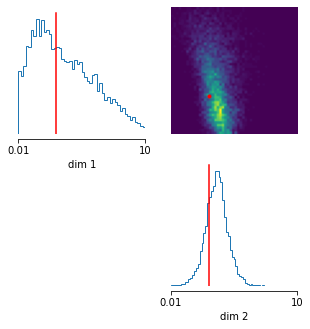

In [17]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=np.array(true_params),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

Second set of parameters

In [18]:
posterior = infer(simulation_wrapper_sinkhorn(synthetic_obs_2), prior, method='SNPE', 
                  num_simulations=1000, num_workers=4)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 156 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

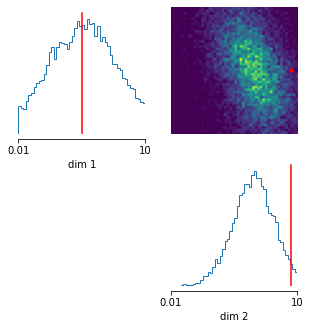

In [19]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=np.array(true_params_2),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

### 10000 iterations

In [58]:
posterior = infer(simulation_wrapper_sinkhorn(synthetic_obs), prior, method='SNPE', 
                  num_simulations=10000, num_workers=4)

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


 Neural network successfully converged after 119 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

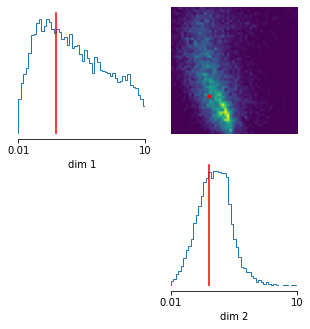

In [21]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=np.array([3.,3.]),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [22]:
posterior = infer(simulation_wrapper_sinkhorn(synthetic_obs_2), prior, method='SNPE', 
                  num_simulations=10000, num_workers=4)

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 64 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

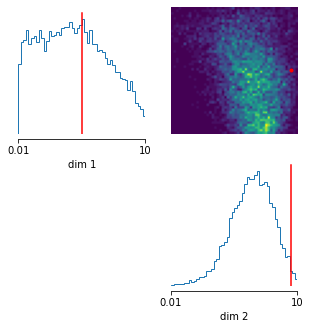

In [23]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=np.array(true_params_2),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

## Multiple Rounds

### 1000 iterations

In [18]:
multi_simulator, prior = prepare_for_sbi(simulation_wrapper_ot(synthetic_obs), prior)
inference = SNPE(prior=prior)

In [19]:
num_rounds = 5
posteriors = []
proposal = prior
x_o = torch.tensor([0])
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=200)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 200 simulations.:   0%|          | 0/200 [00:00<?, ?it/s]

 Neural network successfully converged after 155 epochs.

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations.:   0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

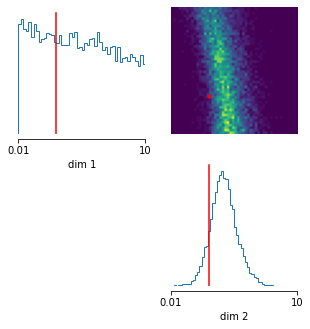

In [26]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=np.array(true_params),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

### 10000 iterations

In [28]:
multi_simulator, prior = prepare_for_sbi(simulation_wrapper_sinkhorn(synthetic_obs), prior)
inference = SNPE(prior=prior)

In [29]:
num_rounds = 10
posteriors = []
proposal = prior
x_o = torch.tensor([0])
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=1000)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 129 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 46 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 42 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 76 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

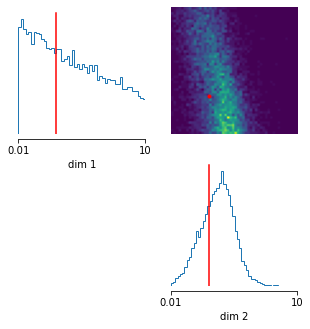

In [30]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=np.array(true_params),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

## Multiple rounds, decreasing distance

100%|██████████| 1000/1000 [01:13<00:00, 13.64it/s]


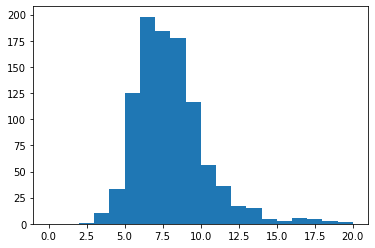

In [38]:
typical_dist_true_params = np.array(torch.cat([simulation_wrapper_ot(synthetic_obs)(true_params) for _ in tqdm(range(1000))]))
plt.hist(typical_dist_true_params,bins=np.linspace(0,20,21))
plt.show()

In [39]:
def simulation_wrapper_ot_reflex(params):
    """
    Uses euclidean distances from a given observation as summary
    """
    obs = simulator(params)['leaves']
    other_obs = simulator(params)['leaves']
    if other_obs.isnan().any() or obs.isnan().any():
        pass
    else:
        distance = ot_dist(obs, other_obs)
    return torch.as_tensor([distance])

100%|██████████| 1000/1000 [01:28<00:00, 11.34it/s]


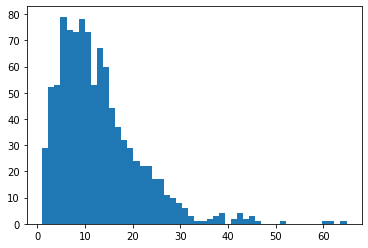

In [40]:
prior_samples = prior.sample((1000,))
typical_distances_overall = np.array(torch.cat([simulation_wrapper_ot_reflex(i) for i in tqdm(prior_samples)]))
plt.hist(typical_distances_overall,bins=50)
plt.show()

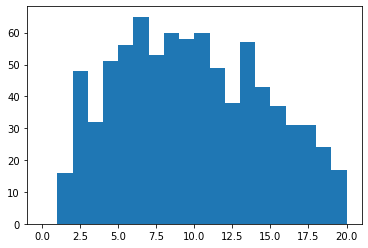

In [41]:
plt.hist(typical_distances_overall,bins=np.linspace(0,20,21))
plt.show()

In [30]:
def simulation_wrapper_ot_disk(data,radius):
    """
    Uses euclidean distances from a given observation as summary
    """
    def parameter_wrapper(params):
        current_obs = simulator(params)['leaves']
        if current_obs.isnan().any():
            distance = np.inf
        else:
            distance = ot_dist(data, current_obs)
        distance = max(distance, radius)
        return torch.as_tensor([distance])
    
    return parameter_wrapper

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 28 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

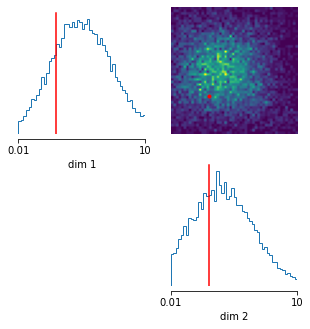

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 86 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

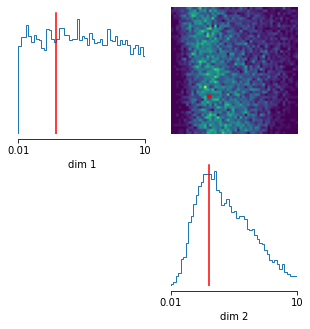

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

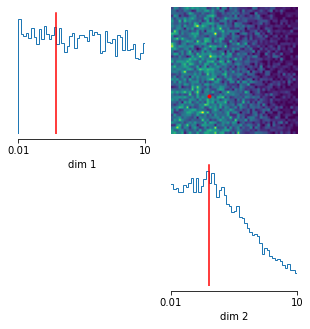

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 53 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

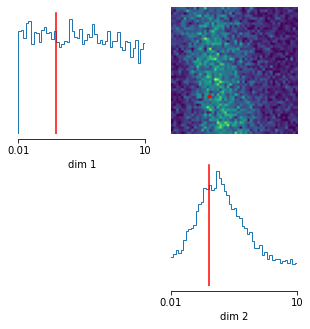

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

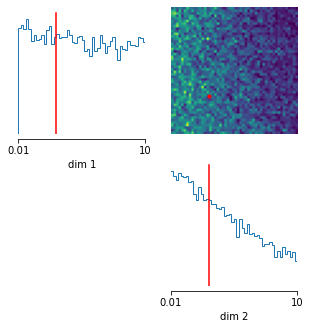

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 73 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9811 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


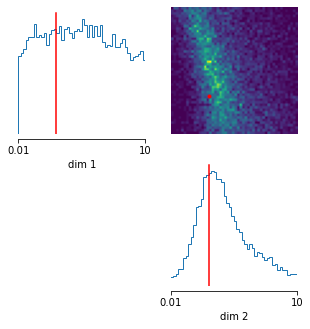

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 205 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 60 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

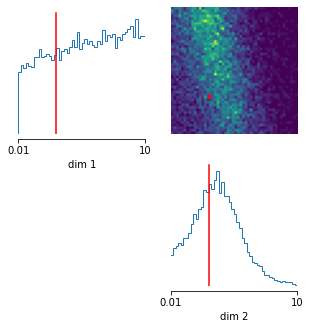

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 112 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

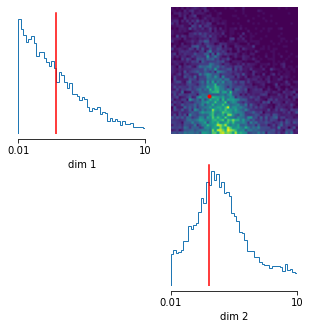

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 53 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

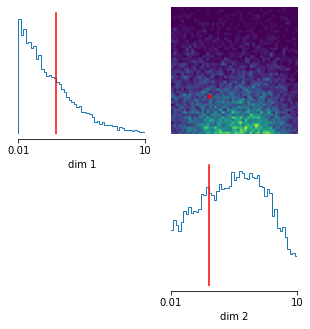

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

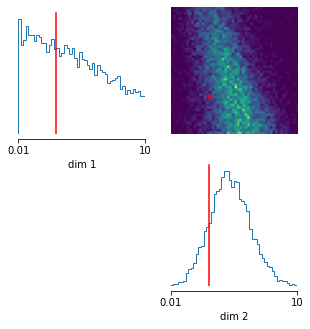

In [36]:
num_rounds = 10
posteriors = []
x_o = torch.linspace(10,1,10)
for i in range(num_rounds):
    multi_simulator, prior = prepare_for_sbi(simulation_wrapper_ot_disk(synthetic_obs,x_o[i]), prior)
    if i == 0:
        proposal = prior
    else:
        proposal = posterior
    inference = SNPE(prior=prior)
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=300, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x([x_o[i]])
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.01,10.], [.01,10.]],
                            ticks=[[.01,10.], [.01,10.]],
                            figsize=(5,5),
                            points=np.array(true_params),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Running 800 simulations in 800 batches.:   0%|          | 0/800 [00:00<?, ?it/s]

 Neural network successfully converged after 82 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

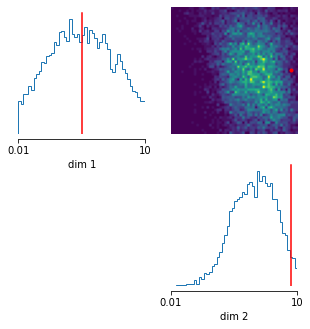

Drawing 800 posterior samples:   0%|          | 0/800 [00:00<?, ?it/s]

Running 800 simulations in 800 batches.:   0%|          | 0/800 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

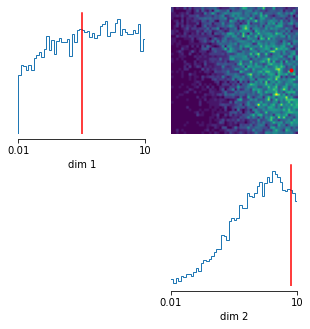

Drawing 800 posterior samples:   0%|          | 0/800 [00:00<?, ?it/s]

Running 800 simulations in 800 batches.:   0%|          | 0/800 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 60 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

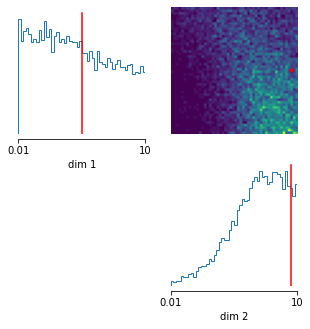

Drawing 800 posterior samples:   0%|          | 0/800 [00:00<?, ?it/s]

Running 800 simulations in 800 batches.:   0%|          | 0/800 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

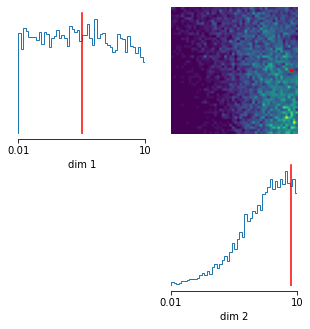

Drawing 800 posterior samples:   0%|          | 0/800 [00:00<?, ?it/s]

Running 800 simulations in 800 batches.:   0%|          | 0/800 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 44 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

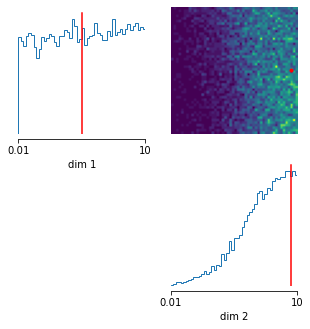

Drawing 800 posterior samples:   0%|          | 0/800 [00:00<?, ?it/s]

Running 800 simulations in 800 batches.:   0%|          | 0/800 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 48 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

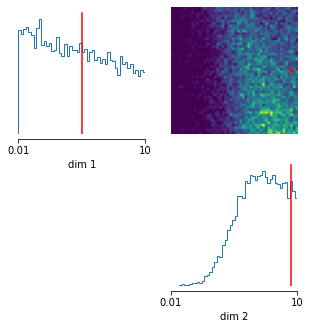

Drawing 800 posterior samples:   0%|          | 0/800 [00:00<?, ?it/s]

Running 800 simulations in 800 batches.:   0%|          | 0/800 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 42 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

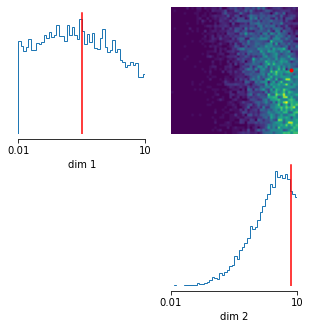

Drawing 800 posterior samples:   0%|          | 0/800 [00:00<?, ?it/s]

Running 800 simulations in 800 batches.:   0%|          | 0/800 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 64 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

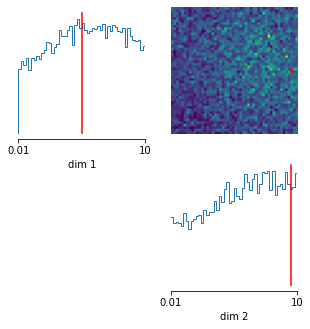

Drawing 800 posterior samples:   0%|          | 0/800 [00:00<?, ?it/s]

Running 800 simulations in 800 batches.:   0%|          | 0/800 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 54 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

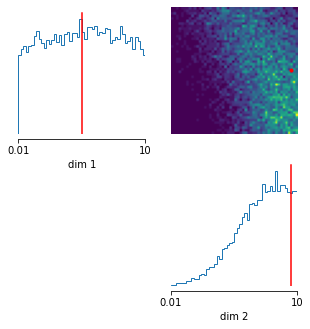

Drawing 800 posterior samples:   0%|          | 0/800 [00:00<?, ?it/s]

Running 800 simulations in 800 batches.:   0%|          | 0/800 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

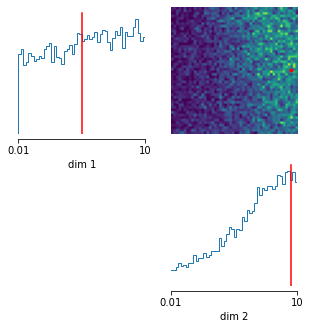

In [53]:
num_rounds = 10
posteriors = []
x_o = torch.linspace(10,1,10)
for i in range(num_rounds):
    multi_simulator, prior = prepare_for_sbi(simulation_wrapper_ot_disk(synthetic_obs_2,x_o[i]), prior)
    if i == 0:
        proposal = prior
    else:
        proposal = posterior
    inference = SNPE(prior=prior)
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=800, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x([x_o[i]])
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.01,10.], [.01,10.]],
                            ticks=[[.01,10.], [.01,10.]],
                            figsize=(5,5),
                            points=np.array(true_params_2),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 166 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

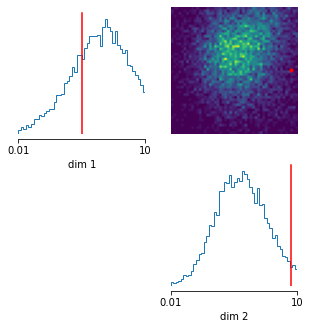

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 76 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

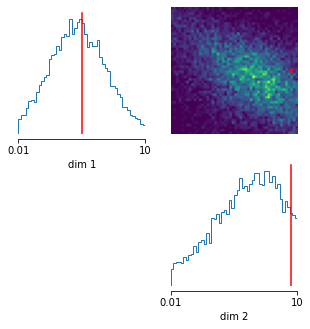

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 109 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

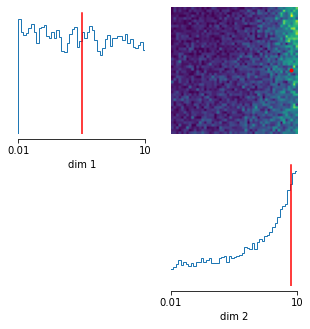

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 46 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

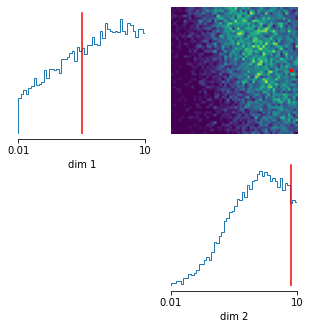

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

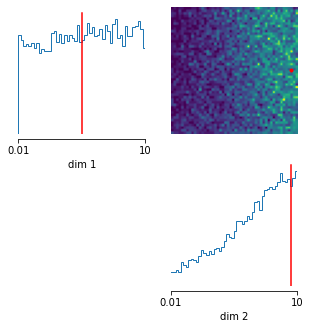

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 58 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

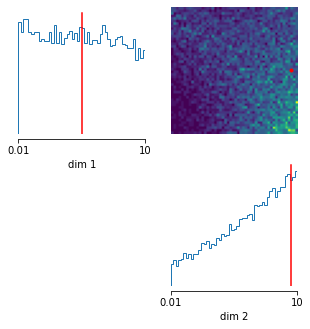

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 45 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

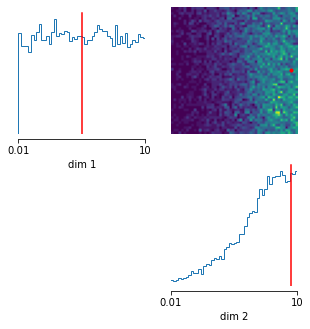

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 133 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9940 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


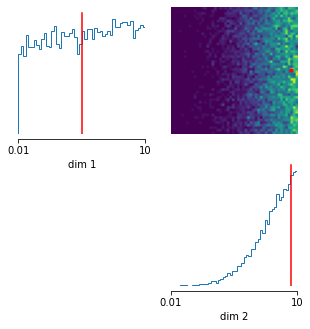

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 228 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

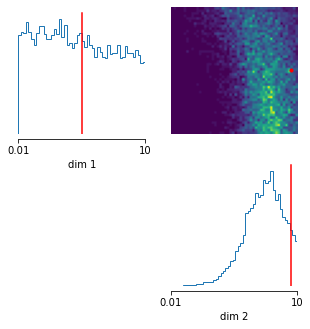

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 42 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

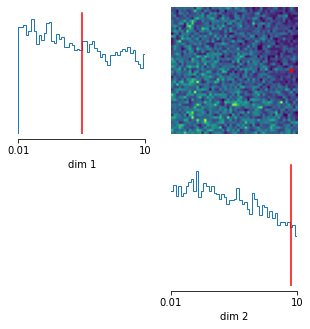

In [44]:
num_rounds = 10
posteriors = []
x_o = torch.tensor([1])
for i in range(num_rounds):
    multi_simulator, prior = prepare_for_sbi(simulation_wrapper_ot_disk(synthetic_obs_2,x_o[0]), prior)
    if i == 0:
        proposal = prior
    else:
        proposal = posterior
    inference = SNPE(prior=prior)
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=300, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x([x_o[0]])
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.01,10.], [.01,10.]],
                            ticks=[[.01,10.], [.01,10.]],
                            figsize=(5,5),
                            points=np.array(true_params_2),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

In [54]:
def simulation_wrapper_ot_disk_2(data,radius_inner, radius_outer):
    """
    Uses euclidean distances from a given observation as summary
    """
    def parameter_wrapper(params):
        current_obs = simulator(params)['leaves']
        if current_obs.isnan().any():
            distance = np.inf
        else:
            distance = ot_dist(data, current_obs)
        distance = max(distance, radius_inner)
        if distance > radius_outer:
            distance = 1000
        return torch.as_tensor([distance])
    
    return parameter_wrapper

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 48 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

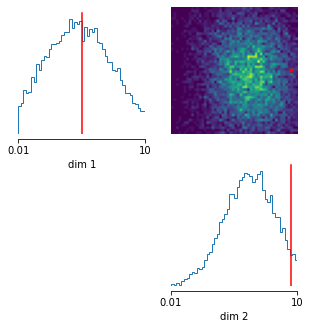

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 42 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

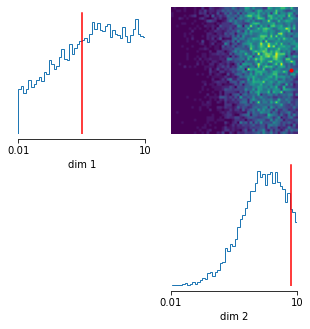

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

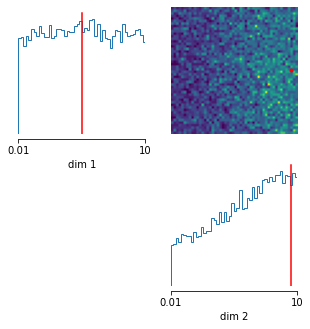

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 60 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

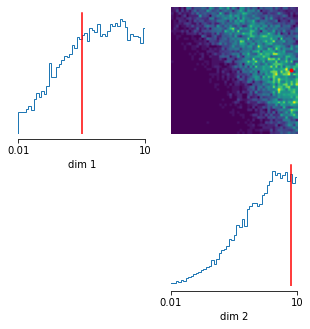

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 52 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

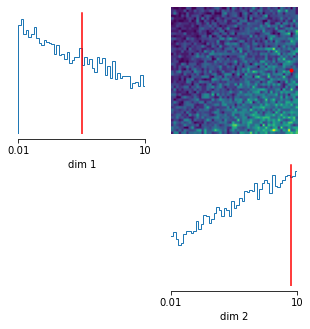

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 59 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

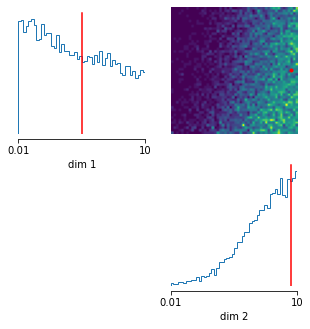

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

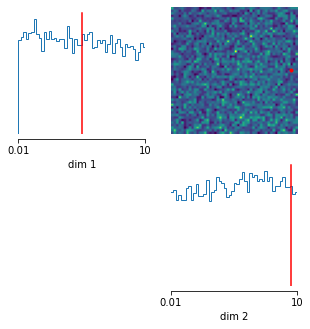

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 48 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

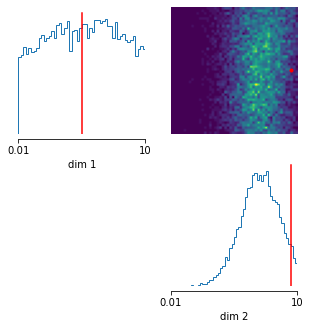

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 57 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

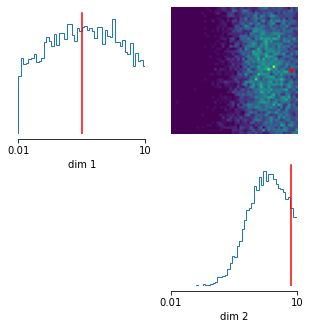

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 66 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

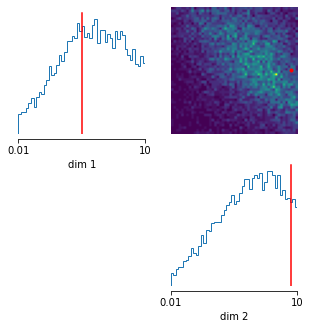

In [56]:
num_rounds = 10
posteriors = []
x_o = torch.tensor([1])
for i in range(num_rounds):
    multi_simulator, prior = prepare_for_sbi(simulation_wrapper_ot_disk_2(synthetic_obs_2,1,10), prior)
    if i == 0:
        proposal = prior
    else:
        proposal = posterior
    inference = SNPE(prior=prior)
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=300, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.01,10.], [.01,10.]],
                            ticks=[[.01,10.], [.01,10.]],
                            figsize=(5,5),
                            points=np.array(true_params_2),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 33 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

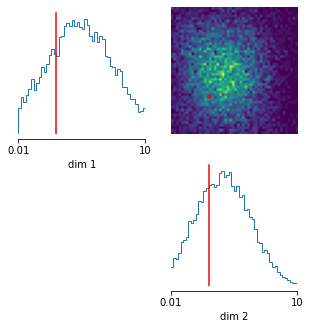

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

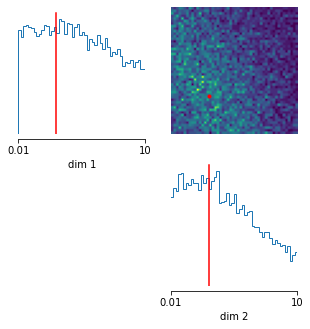

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 64 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

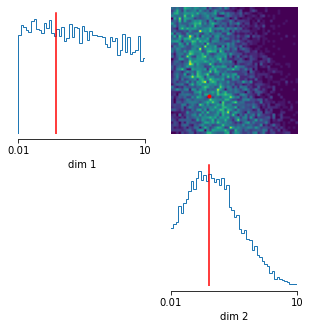

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 65 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

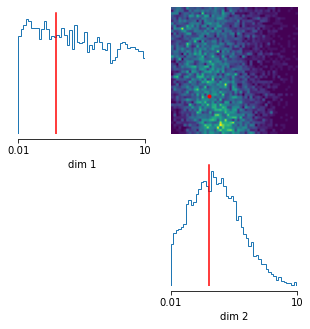

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

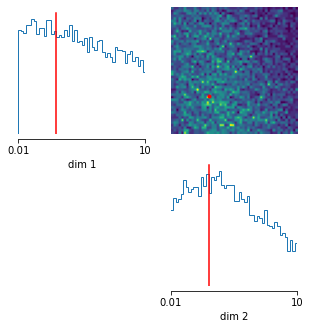

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

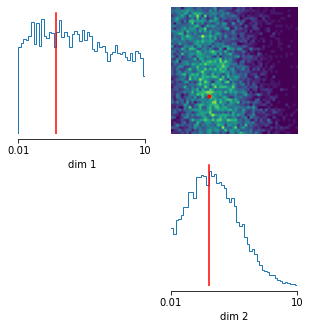

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

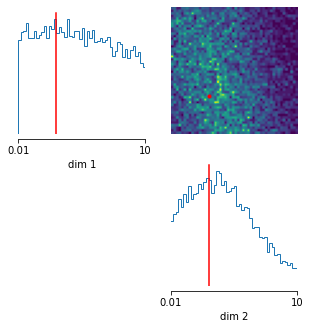

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 91 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

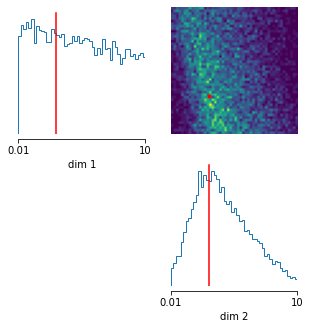

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 44 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

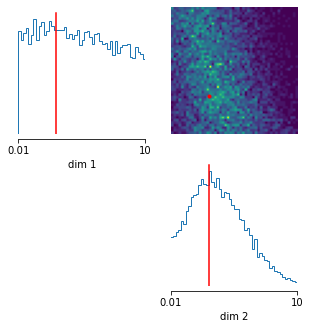

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

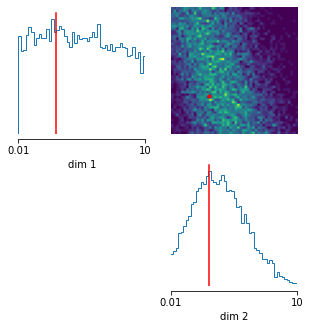

In [57]:
num_rounds = 10
posteriors = []
x_o = torch.tensor([1])
for i in range(num_rounds):
    multi_simulator, prior = prepare_for_sbi(simulation_wrapper_ot_disk_2(synthetic_obs,1,10), prior)
    if i == 0:
        proposal = prior
    else:
        proposal = posterior
    inference = SNPE(prior=prior)
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=300, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.01,10.], [.01,10.]],
                            ticks=[[.01,10.], [.01,10.]],
                            figsize=(5,5),
                            points=np.array(true_params),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

In [59]:
posterior = infer(simulation_wrapper_ot_disk(synthetic_obs,3), prior, method='SNPE', 
                  num_simulations=10000, num_workers=4)

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 148 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

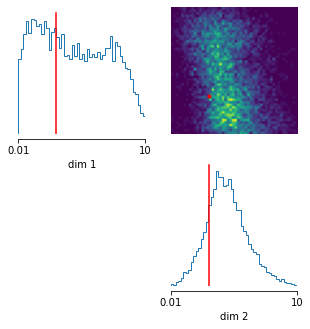

In [61]:
samples = posterior.sample((10000,),x=3)
fig, axes = analysis.pairplot(samples,
                        limits=[[.01,10.], [.01,10.]],
                        ticks=[[.01,10.], [.01,10.]],
                        figsize=(5,5),
                        points=np.array(true_params),
                        points_offdiag={'markersize': 6},
                        points_colors='r');

## OT Distance

In [62]:
posterior = infer(simulation_wrapper_ot(synthetic_obs), prior, method='SNPE', 
                  num_simulations=1000, num_workers=4)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 112 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

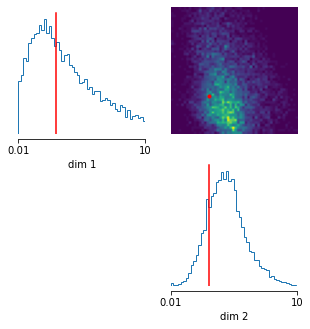

In [63]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=np.array(true_params),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [64]:
posterior = infer(simulation_wrapper_ot(synthetic_obs), prior, method='SNPE', 
                  num_simulations=10000, num_workers=4)

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 141 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

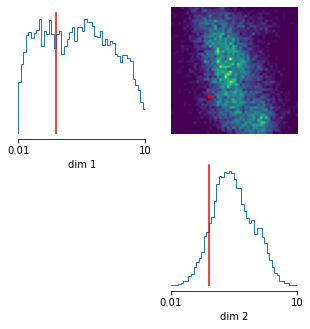

In [65]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=np.array(true_params),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [64]:
posterior = infer(simulation_wrapper_ot(synthetic_obs), prior, method='SNPE', 
                  num_simulations=10000, num_workers=4)

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 90 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

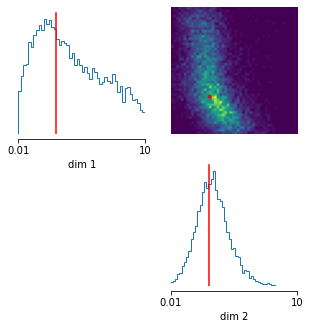

In [65]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=np.array(true_params),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [66]:
posterior = infer(simulation_wrapper_ot(synthetic_obs_2), prior, method='SNPE', 
                  num_simulations=10000, num_workers=4)

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


 Neural network successfully converged after 127 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

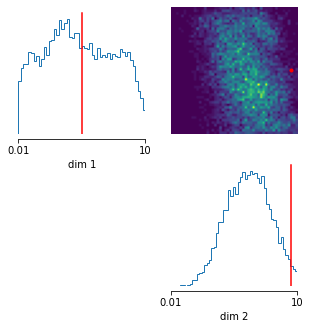

In [68]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=np.array(true_params_2),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 79 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

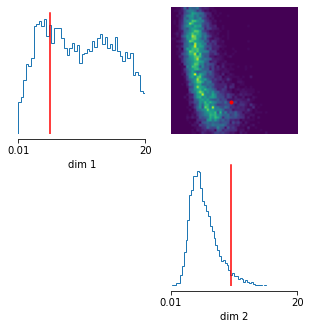

In [ ]:
wide_prior_min = [1e-3,1e-3]
wide_prior_max = [20.,20.]
wide_prior = utils.torchutils.BoxUniform(low=torch.as_tensor(wide_prior_min), 
                                    high=torch.as_tensor(wide_prior_max))
posterior = infer(simulation_wrapper_ot(synthetic_obs_2), wide_prior, method='SNPE', 
                  num_simulations=5000, num_workers=7)
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,20.], [.01,20.]],
                           ticks=[[.01,20.], [.01,20.]],
                           figsize=(5,5),
                           points=np.array(true_params_2),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

## Multi-round OT

In [111]:
multi_simulator, prior = prepare_for_sbi(simulation_wrapper_ot(synthetic_obs), prior)
inference = SNPE(prior=prior)

In [114]:
num_rounds = 5
posteriors = []
proposal = prior
x_o = torch.tensor([0])
for i in range(num_rounds):
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=1000, num_workers = 7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 81 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 52 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

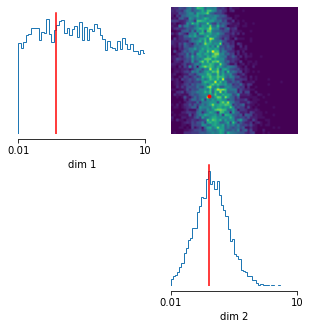

In [117]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=np.array(true_params),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [118]:
multi_simulator, prior = prepare_for_sbi(simulation_wrapper_ot(synthetic_obs_2), prior)
inference = SNPE(prior=prior)
num_rounds = 5
posteriors = []
proposal = prior
x_o = torch.tensor([0])
for i in range(num_rounds):
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=1000, num_workers = 7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 89 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 57 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

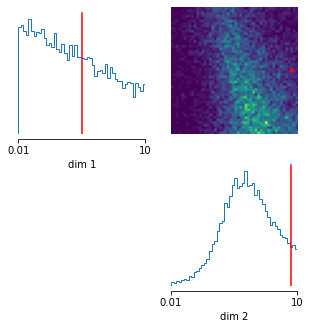

In [119]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=np.array(true_params_2),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

## With summaries
Seems that the second set of observations are misbehaving. Will summaries help?

In [102]:
def summaries(leaves, reference_obs):

    leaf_count = torch.as_tensor(len(leaves))
    energy_variance = torch.as_tensor(leaves[:,0].var())
    if leaves.isnan().any():
        distance = torch.as_tensor(np.inf)
    else:
        distance = torch.as_tensor(sinkhorn_t(leaves, reference_obs))
  

    all_summs = torch.tensor([leaf_count, energy_variance, distance])

    return all_summs

def all_sums_wrapper(data):
    """
    Produces a wrapper for a function returning summaries.
    """
    def parameter_wrapper(params):
        leaves = simulator(params)['leaves']
        return summaries(leaves, data)

    return parameter_wrapper

In [107]:
x_o=summaries(synthetic_obs_2, synthetic_obs_2)

tensor([ 20.0000, 466.6735,   0.0000])

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


 Neural network successfully converged after 231 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

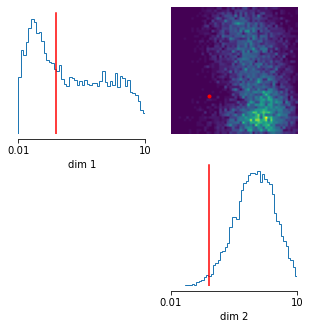

In [109]:
posterior = infer(all_sums_wrapper(synthetic_obs), prior, method='SNPE', 
                  num_simulations=5000, num_workers=7)
samples = posterior.sample((10000,), 
                           x=x_o)


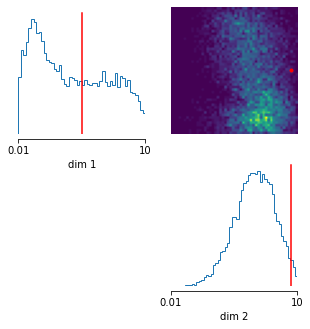

In [110]:
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params_2,
                           points_offdiag={'markersize': 6},
                           points_colors='r');    

## MSE Checks

In [35]:
def MSE(posterior, true_params, num_samples = 10000):
    samples = posterior.sample((num_samples,), 
                           x=torch.tensor([0]))
    loss = torch.nn.MSELoss()
    return loss(samples, true_params)

In [55]:
for post in posteriors:
    print(MSE(post,true_params))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(5.0716)


/home/sragy/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([10000, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(6.9887)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9923 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


tensor(7.0434)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9910 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


tensor(6.8387)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9602 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


tensor(6.9085)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(7.4851)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(7.2618)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(7.2606)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(7.2647)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(7.3592)


## ABC

In [46]:
def dist_from_params(data, params):
    current_obs = simulator(params)['leaves']
    if current_obs.isnan().any():
        distance = np.inf
    else:
        distance = ot_dist(data, current_obs)
    return distance

def closest_k_of_n(data,prior,k,n, num_workers = 1):
    params = prior.sample((n,))
    distances = Parallel(n_jobs=num_workers, verbose=5)(
        delayed(dist_from_params)(data, inp) for inp in params)
    distances = torch.tensor(distances)
    indices = distances.topk(k, largest=False).indices
    return params[indices]

In [47]:
samples = closest_k_of_n(synthetic_obs,prior,1000,20000, num_workers = 7)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=7)]: Done 102 tasks      | elapsed:    2.1s
[Parallel(n_jobs=7)]: Done 282 tasks      | elapsed:    5.3s
[Parallel(n_jobs=7)]: Done 534 tasks      | elapsed:    9.8s
[Parallel(n_jobs=7)]: Done 858 tasks      | elapsed:   15.6s
 97%|█████████▋| 970/1000 [22:56<00:42,  1.42s/it]
[Parallel(n_jobs=7)]: Done 1254 tasks      | elapsed:   22.4s
[Parallel(n_jobs=7)]: Done 1722 tasks      | elapsed:   30.2s
[Parallel(n_jobs=7)]: Done 2262 tasks      | elapsed:   39.5s
[Parallel(n_jobs=7)]: Done 2874 tasks      | elapsed:   50.5s
[Parallel(n_jobs=7)]: Done 3558 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 4314 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done 5142 tasks      | elapsed:  1.6min
[Parallel(n_jobs=7)]: Done 6042 tasks      | elapsed:  1.9min
[Parallel(n_jobs=7)]: Done 7014 tasks      | elapsed:  2.3min
[Parallel(n

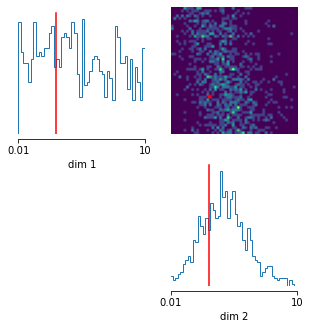

In [48]:
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=np.array(true_params),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 102 tasks      | elapsed:    1.2s
[Parallel(n_jobs=7)]: Done 282 tasks      | elapsed:    3.7s
[Parallel(n_jobs=7)]: Done 534 tasks      | elapsed:    8.3s
[Parallel(n_jobs=7)]: Done 858 tasks      | elapsed:   13.6s
[Parallel(n_jobs=7)]: Done 1254 tasks      | elapsed:   20.1s
[Parallel(n_jobs=7)]: Done 1722 tasks      | elapsed:   28.4s
[Parallel(n_jobs=7)]: Done 2262 tasks      | elapsed:   37.2s
[Parallel(n_jobs=7)]: Done 2874 tasks      | elapsed:   45.3s
[Parallel(n_jobs=7)]: Done 3558 tasks      | elapsed:   53.2s
[Parallel(n_jobs=7)]: Done 4314 tasks      | elapsed:  1.0min
[Parallel(n_jobs=7)]: Done 5142 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 6042 tasks      | elapsed:  1.4min
[Parallel(n_jobs=7)]: Done 7014 tasks      | elapsed:  1.6min
[Parallel(n_jobs=7)]: Done 8058 tasks      | elapsed:  1.8min


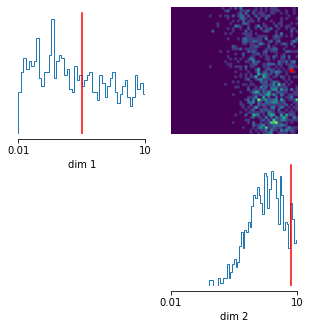

In [52]:
samples = closest_k_of_n(synthetic_obs_2,posteriors[-2],1000,10000, num_workers = 7)
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=np.array(true_params_2),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

## Rough calculations

In [49]:
true_params_stack=torch.stack([true_params for i in range(10000)],)

In [50]:
for post in posteriors:
    print(MSE(post,true_params_stack))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(5.4312)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(6.1469)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(5.8915)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(6.4325)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(5.9415)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(5.9281)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(6.0042)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(6.0079)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(5.7667)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(5.5295)


In [83]:
test=torch.tensor([[1,2,3,4,5],[6,7,8,9,10],[0,13,14,15,16]])
test.topk(2,axis=1).indices


tensor([[4, 3],
        [4, 3],
        [4, 3]])

## ABC

In [45]:
samples = closest_k_of_n(synthetic_obs,prior,1000,20000, num_workers = 7)


NameError: name 'closest_k_of_n' is not defined